# Machine Learning e previsão de série temporal

## Configuração

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go

import sklearn as sk
from sklearn.preprocessing import MinMaxScaler

import statsmodels
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.models import load_model

import kaleido

In [2]:
pio.renderers.default = 'png'
pio.templates.default = "ggplot2"
px.defaults.width = 900
px.defaults.height = 500

pxconfig = {'staticPlot': True}

In [3]:
## Importação dos dados

In [4]:
df = pd.read_csv('../dados/trabalhados/gastos_serie_temporal.csv',parse_dates=['DATA'], index_col=0)
df.rename(columns={'VALOR_REEMBOLSADO': 'VALOR'}, inplace=True)
df.set_index(['DATA'], inplace=True)
df = df.loc[df.index < '2022-04-01']
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4108 entries, 2011-01-01 to 2022-03-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   VALOR   4108 non-null   float64
dtypes: float64(1)
memory usage: 64.2 KB


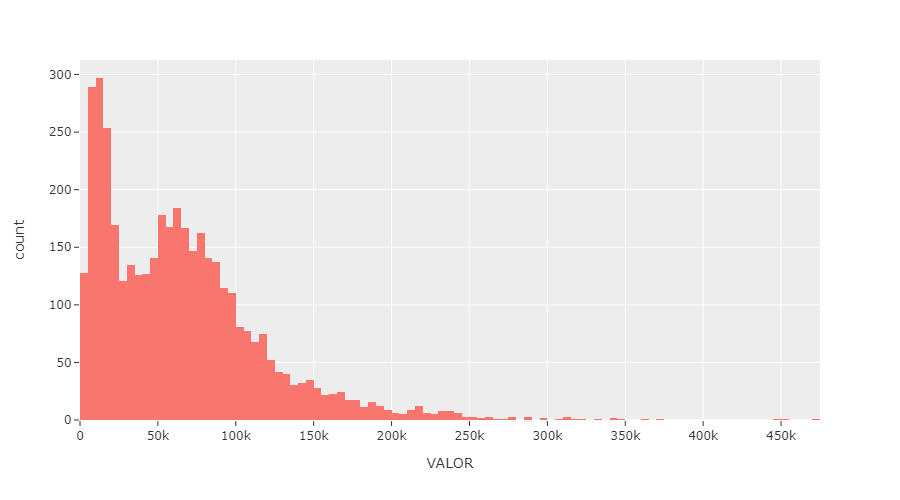

In [5]:
fig = px.histogram(df, x='VALOR', )
fig.show(config=pxconfig)

## Regressão Linear

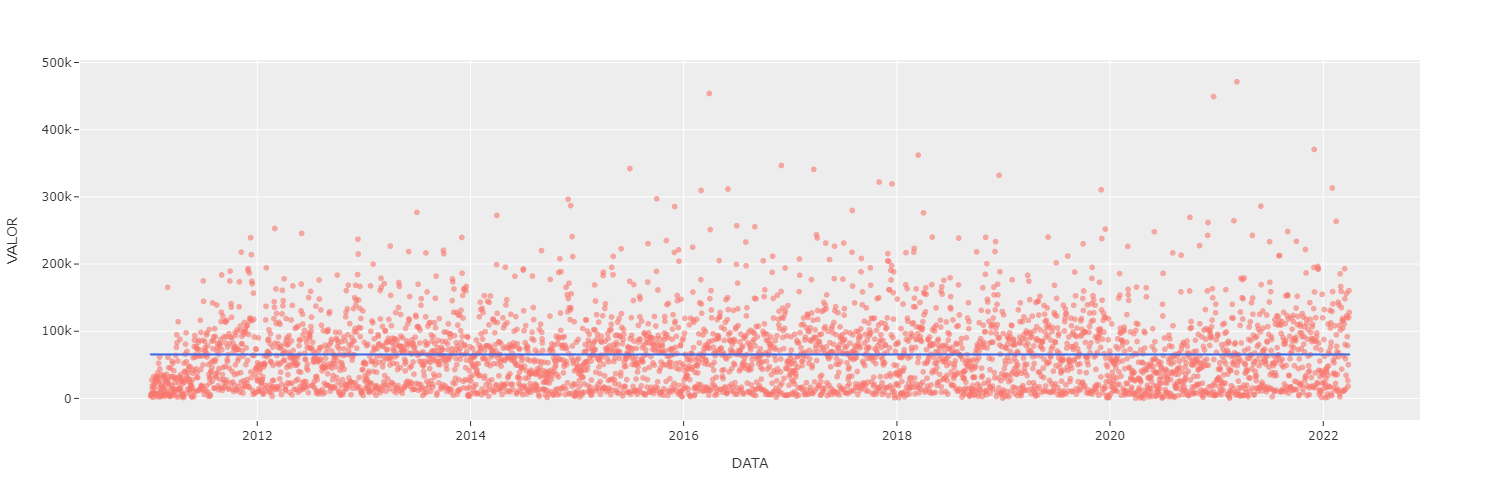

In [6]:
fig = px.scatter(df, x=df.index, y='VALOR', opacity=0.6, trendline='ols', trendline_color_override='royalblue', width=1500)
fig.show(config=pxconfig)

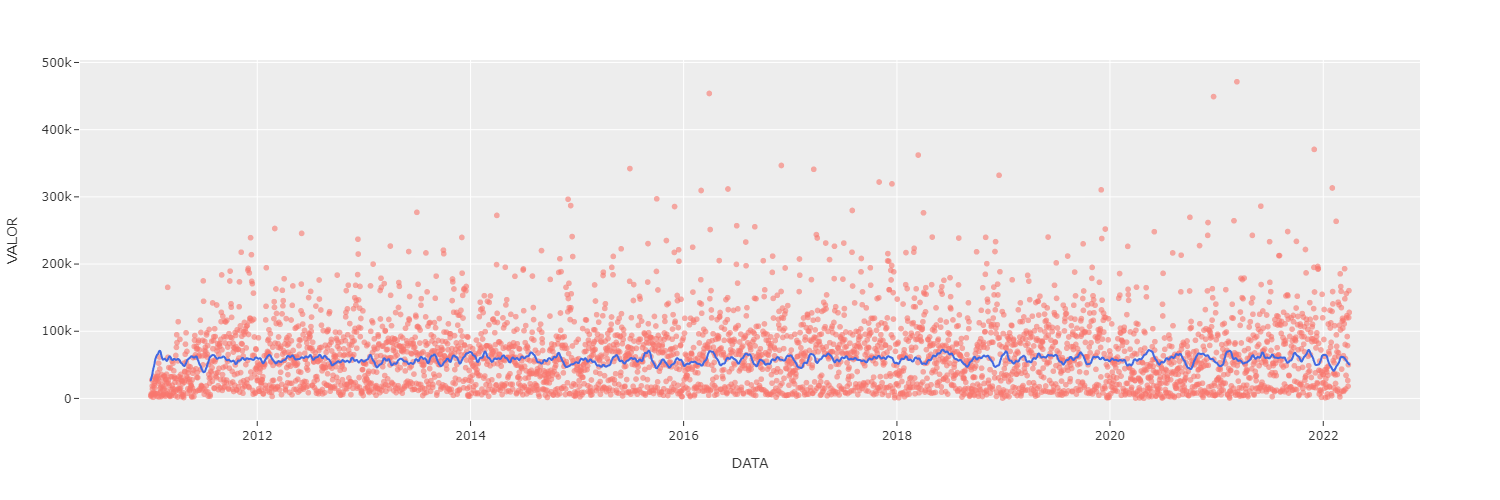

In [7]:
fig = px.scatter(df, x=df.index, y='VALOR', opacity=0.6, trendline='lowess', trendline_color_override='royalblue', trendline_options=dict(frac=0.01), width=1500)
fig.show(config=pxconfig)

## Média dos últimos 3 meses

In [8]:
media_3_meses = df.rolling('30D').mean()

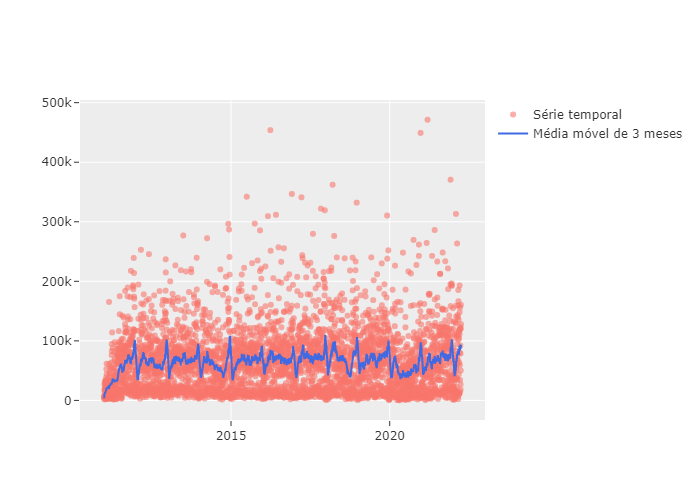

In [9]:
fig = go.Figure([
    go.Scatter(x = df.index, y=df['VALOR'], mode='markers', marker={'opacity': 0.6}, name='Série temporal'),
    go.Scatter(x = media_3_meses.index, y = media_3_meses['VALOR'], mode='lines', line={'color': 'royalblue'}, name='Média móvel de 3 meses')
])
fig.show(config=pxconfig)

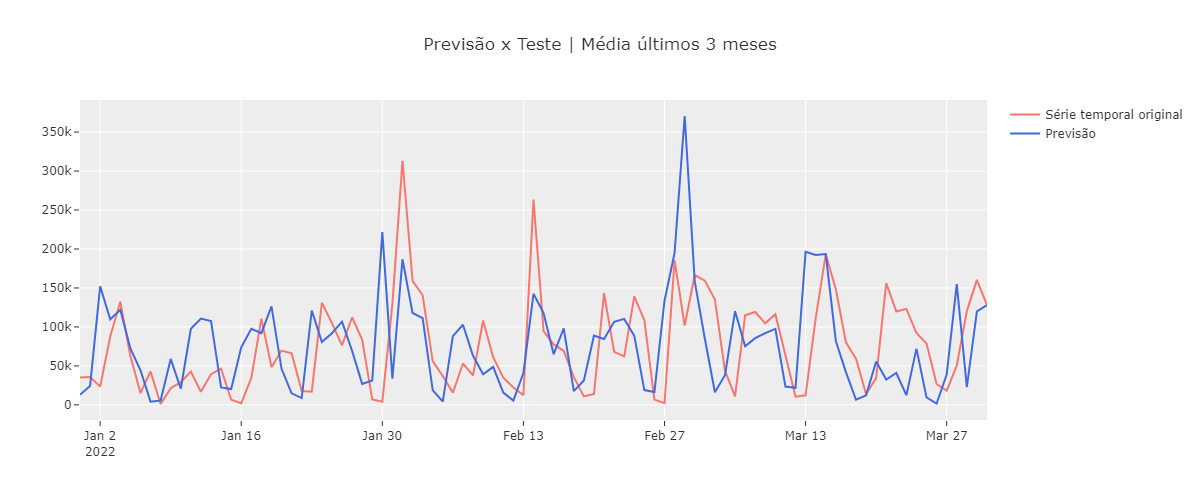

In [10]:
# Criar um append no array de 'VALOR'. Ese novo valor é a média dos últimos 3 meses

dias_anterioes = 90
dias_previsto = 30

prev_3meses = df.copy()

#prev_3meses.iloc[-1, 0] = prev_3meses.iloc[-91, 0].mean()
for i in range(dias_anterioes):
    prev_3meses.iloc[(-dias_anterioes-1+i), 0] = prev_3meses.iloc[(-dias_anterioes-1+i-dias_anterioes), 0].mean()
prev_3meses

fig = go.Figure([
    go.Scatter(x = df.iloc[(-dias_anterioes-1):].index, y=df.iloc[(-dias_anterioes-1):]['VALOR'], mode='lines', name='Série temporal original'),
    go.Scatter(x = prev_3meses.iloc[(-dias_anterioes-1):].index, y = prev_3meses.iloc[(-dias_anterioes-1):]['VALOR'], mode='lines', line={'color': 'royalblue'}, name='Previsão')
])

fig.update_layout(title_text='Previsão x Teste | Média últimos 3 meses',
                height=500,
                width=1200
)

fig.write_image("../plots/Media_3_meses.jpeg")

fig.show(config=pxconfig)

# Modelo ARIMA

In [11]:
adfuller(df['VALOR'])

(-6.743255177031651,
 3.080445367924359e-09,
 30,
 4077,
 {'1%': -3.4319549600249886,
  '5%': -2.8622491834480193,
  '10%': -2.567147505270297},
 98278.23914506283)

Pelo resultado do teste ADF é possível concluir que a série é estacionária, indicando que ela já está pronta para ser usada em um modelo

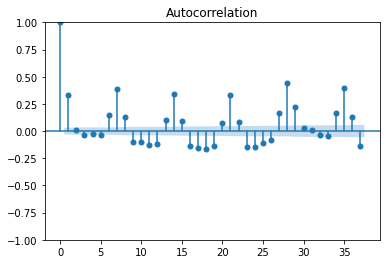

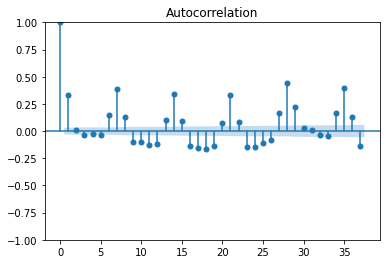

In [12]:
plot_acf(df['VALOR'])


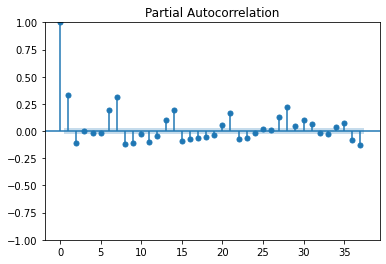

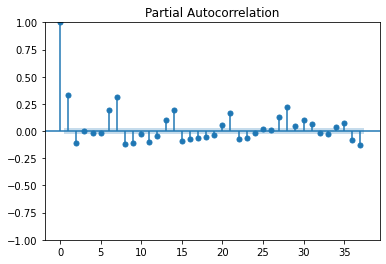

In [13]:
plot_pacf(df['VALOR'], method='ywm')

Utilizando esses gráficos não cheguei num bom resultado.
A próxima metodologia utiliza foi sugerida nesse vídeo, utilizando a biblioteca `pmdarima`: https://www.youtube.com/watch?v=8FCDpFhd1zk


In [14]:
from pmdarima import auto_arima

In [15]:
stepwise_fit = auto_arima(df, trace=True, suppress_warnings=True)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=100486.926, Time=4.48 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=102236.654, Time=0.20 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=101950.884, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=101015.213, Time=0.70 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=102234.655, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=100521.354, Time=1.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=100592.152, Time=0.91 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=100502.133, Time=2.35 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=100474.498, Time=2.31 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=100550.640, Time=1.72 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=5.76 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=6.57 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=100542.351, Time=2.13 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=6.69 sec
 ARIMA(2,1,3)(0,0,0)[0]   

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 4108
Model:               SARIMAX(2, 1, 3)   Log Likelihood              -50228.710
Date:                Thu, 09 Jun 2022   AIC                         100469.420
Time:                        14:24:11   BIC                         100507.343
Sample:                             0   HQIC                        100482.845
                               - 4108                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5477      0.045    -12.249      0.000      -0.635      -0.460
ar.L2         -0.5433      0.027    -19.782      0.000      -0.597      -0.489
ma.L1         -0.1292      0.043     -2.993      0.003      -0.214      -0.045
ma.L2         -0.1743      0.035     -4.930      0.000      -0.244      -0.105
ma.L3         -0.6626      0.027    -24.785      0.000      -0.715      -0.610
sigma2      2.723e+09   7.49e-12   3.64e+20      0.000    2.72e+09    2.72e+09
===================================================================================
Ljung-Box (L1) (Q):                  10.80   Jarque-Bera (JB):              7404.65
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.56   Skew:                             1.64
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.76e+35. Standard errors may be unstable.
"""

In [16]:
model = statsmodels.tsa.arima.model.ARIMA(df['VALOR'], order = (1, 0, 0))

model = model.fit()
model.summary()

d:\Analise de Dados\Senado - Analise de dados CEAPS\ambiente-virtual\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

d:\Analise de Dados\Senado - Analise de dados CEAPS\ambiente-virtual\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

d:\Analise de Dados\Senado - Analise de dados CEAPS\ambiente-virtual\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  VALOR   No. Observations:                 4108
Model:                 ARIMA(1, 0, 0)   Log Likelihood              -50292.842
Date:                Thu, 09 Jun 2022   AIC                         100591.684
Time:                        14:24:12   BIC                         100610.646
Sample:                    01-01-2011   HQIC                        100598.397
                         - 03-31-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       6.545e+04   1184.327     55.265      0.000    6.31e+04    6.78e+04
ar.L1          0.3312      0.011     29.254      0.000       0.309       0.353
sigma2       2.52e+09      0.030   8.32e+10      0.000    2.52e+09    2.52e+09
===================================================================================
Ljung-Box (L1) (Q):                   5.64   Jarque-Bera (JB):              7321.64
Prob(Q):                              0.02   Prob(JB):                         0.00
Heteroskedasticity (H):               1.47   Skew:                             1.67
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.47e+24. Standard errors may be unstable.
"""

Como a base de dados tem 4168 registros, vou criar uma base de teste com 10% desse valor, o restante fica para treino

In [17]:
test_size=90

df_train = df.iloc[:-test_size]
df_test = df.iloc[-test_size:]
print(df_train.shape, df_test.shape)
df_test

(4018, 1) (90, 1)


,VALOR
DATA,
2022-01-01,35757.04
2022-01-02,23383.75
2022-01-03,87695.02
2022-01-04,132330.45
2022-01-05,62597.65
...,...
2022-03-27,18158.71
2022-03-28,50201.57
2022-03-29,120321.97


In [18]:
model = statsmodels.tsa.arima.model.ARIMA(df_train['VALOR'], order = (2, 1, 3), freq='D')
model = model.fit()
model.summary()

d:\Analise de Dados\Senado - Analise de dados CEAPS\ambiente-virtual\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  VALOR   No. Observations:                 4018
Model:                 ARIMA(2, 1, 3)   Log Likelihood              -49118.583
Date:                Thu, 09 Jun 2022   AIC                          98249.166
Time:                        14:24:14   BIC                          98286.956
Sample:                    01-01-2011   HQIC                         98262.559
                         - 12-31-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5519      0.047    -11.782      0.000      -0.644      -0.460
ar.L2         -0.5381      0.028    -19.065      0.000      -0.593      -0.483
ma.L1         -0.1265      0.045     -2.797      0.005      -0.215      -0.038
ma.L2         -0.1820      0.037     -4.945      0.000      -0.254      -0.110
ma.L3         -0.6572      0.028    -23.782      0.000      -0.711      -0.603
sigma2      2.709e+09    7.7e-12   3.52e+20      0.000    2.71e+09    2.71e+09
===================================================================================
Ljung-Box (L1) (Q):                   9.99   Jarque-Bera (JB):              7438.52
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.51   Skew:                             1.65
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.88e+36. Standard errors may be unstable.
"""

In [19]:
start = len(df_train)
end = len(df_train) + len(df_test) -1
pred = model.predict(start=start, end=end, typ='levels')
pred = pred.to_frame().rename(columns={'predicted_mean': 'VALOR'})
pred


,VALOR
2022-01-01,75271.079481
2022-01-02,57943.809501
2022-01-03,84904.667913
2022-01-04,79347.050687
2022-01-05,67908.186104
...,...
2022-03-27,75304.628643
2022-03-28,75304.628643
2022-03-29,75304.628643
2022-03-30,75304.628643


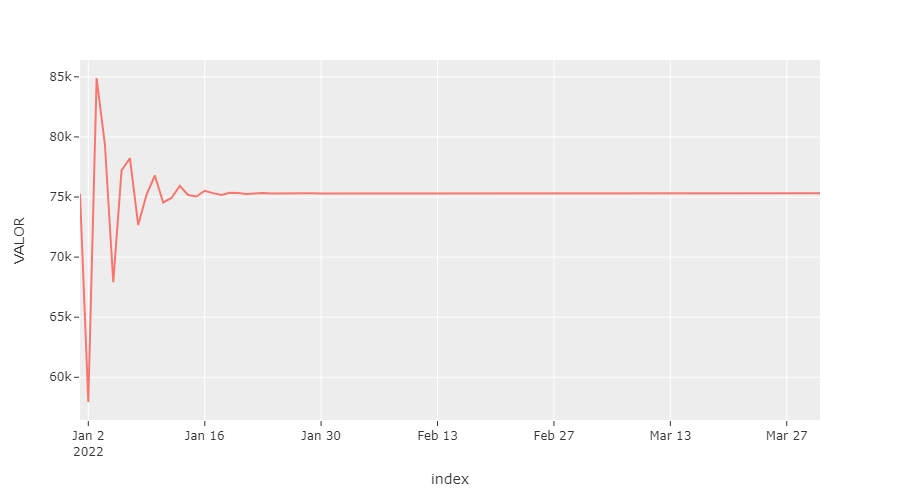

In [20]:
fig = px.line(pred, x=pred.index, y='VALOR')
fig.show(config=pxconfig)

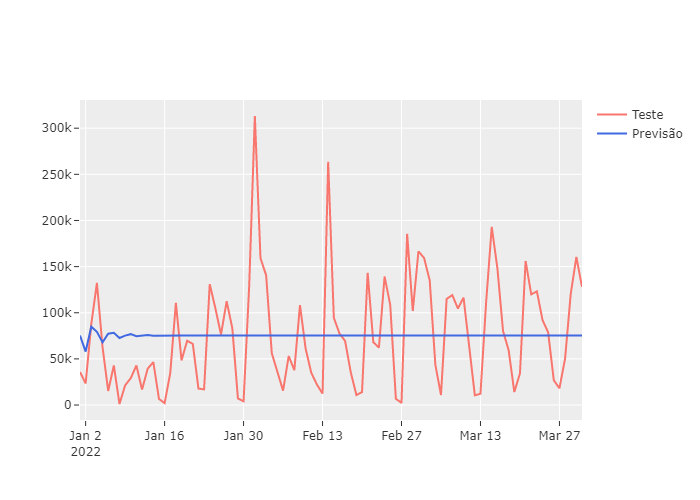

In [21]:
fig = go.Figure([
    go.Scatter(x = df_test.index, y=df_test['VALOR'], mode='lines', name='Teste'),
    go.Scatter(x = pred.index, y = pred['VALOR'], mode='lines', line={'color': 'royalblue'}, name='Previsão')
])

fig.show()

# Modelo LSTM

Baseado nesse vídeo: https://www.youtube.com/watch?v=S8tpSG6Q2H0

In [22]:
test_size=90

df_train = df.iloc[:-test_size]
df_test = df.iloc[-test_size:]
print(df_train.shape, df_test.shape)

(4018, 1) (90, 1)


É necessário transformar toda a série para uma escala de 0 a 1. Dessa forma o modelo tem melhor desempenho e não fica confuso se tiver uma mudança de escala entre os dados pra treino e os dados pra teste. (Acho que isso é mais importante no caso de séries não estacionárias, que não é tanto este caso)

In [23]:
scaler = MinMaxScaler()
scaler.fit(df_train)
scaled_train = scaler.transform(df_train)
scaled_test = scaler.transform(df_test)
scaled_train

array([[0.00935894],
       [0.00599854],
       [0.01441417],
       ...,
       [0.047956  ],
       [0.25412663],
       [0.0741919 ]])

A partir dos dados transformados é necessário criar uma novas TimeSeries para o treinamento e previsão. A maneira como esse modelo funciona é que ele pega um quantidade n de números e prevê o n+1. Depois ele faz uma nova lista de n números, desprezando o primeiro e anexando no fim o número previsto, assim fazendo mais uma previsão.
`1, 2, 3 prevê=> 4 | 2, 3, 4 prevê=> 5 | 3, 4, 5 prevê=> 6 | e por aí vai...`

In [24]:
# Demonstração do gerador de TimeSeries

n_input = 5 # Tamanho do Array
n_features = 1 # Quantidade de TimeSeries
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

for i in range(3):
    X, y = generator[i]
    print(f"Batch nº{i}: O array {X.flatten()}\n previu o resultado {y}" )

Batch nº0: O array [0.00935894 0.00599854 0.01441417 0.0113196  0.05778529]
 previu o resultado [[0.03872775]]
Batch nº1: O array [0.00599854 0.01441417 0.0113196  0.05778529 0.03872775]
 previu o resultado [[0.02911669]]
Batch nº2: O array [0.01441417 0.0113196  0.05778529 0.03872775 0.02911669]
 previu o resultado [[0.01441911]]


In [25]:
# Gerando para 3 meses (90 dias)

n_input = 90 # Tamanho do Array
n_features = 1 # Quantidade de TimeSeries
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)


In [26]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [27]:
# model.fit(generator, epochs=20)

In [28]:
model = load_model('../models/LSTM-20-epochs-90-dias')

In [29]:
# loss = model.history.history['loss']
# plt.plot(range(len(loss)), loss)

In [30]:
# model.save('../models/LSTM-20-epochs-90-dias')

In [31]:
last_train_batch = scaled_train[-n_input:] # Os últimos noventa dias do conjunto de treino que vai servir para prever o primeiro dia do conjunto de teste
last_train_batch = last_train_batch.reshape((1, n_input, n_features)) # Formatação pra ficar igual o modelo OBS: Estudar melhor isso

In [32]:
# Prevendo o primeiro dia do conjunto de teste

model.predict(last_train_batch)

1/1 [==============================] - 2s 2s/step


array([[0.08597204]], dtype=float32)

In [33]:
# O valore real do primeiro dia de teste
scaled_test[0]

array([0.07533325])

In [34]:
all_predictions = []
initial_batch = last_train_batch

for i in range(len(df_test)):
    pred = model.predict(initial_batch)[0]
    all_predictions.append(pred)
    initial_batch = np.append(initial_batch[:, 1:, :], [[pred]], axis=1)

1/1 [==============================] - 0s 21ms/step


In [35]:
all_predictions

[array([0.08597204], dtype=float32),
 array([0.04762104], dtype=float32),
 array([0.10557503], dtype=float32),
 array([0.18897043], dtype=float32),
 array([0.18727988], dtype=float32),
 array([0.19591345], dtype=float32),
 array([0.18560311], dtype=float32),
 array([0.13347726], dtype=float32),
 array([0.06620899], dtype=float32),
 array([0.0661459], dtype=float32),
 array([0.24396354], dtype=float32),
 array([0.20709755], dtype=float32),
 array([0.20946221], dtype=float32),
 array([0.20694567], dtype=float32),
 array([0.16850586], dtype=float32),
 array([0.09375529], dtype=float32),
 array([0.04291995], dtype=float32),
 array([0.149806], dtype=float32),
 array([0.19539116], dtype=float32),
 array([0.19293545], dtype=float32),
 array([0.1974044], dtype=float32),
 array([0.18141], dtype=float32),
 array([0.12402932], dtype=float32),
 array([0.05840943], dtype=float32),
 array([0.08218302], dtype=float32),
 array([0.23391885], dtype=float32),
 array([0.20616016], dtype=float32),
 array([

In [36]:
all_predictions = scaler.inverse_transform(all_predictions)
all_predictions

array([[ 40768.38656292],
       [ 22703.33985086],
       [ 50002.27346658],
       [ 89285.25943445],
       [ 88488.93360547],
       [ 92555.73271459],
       [ 87699.1004596 ],
       [ 63145.47857307],
       [ 31459.10030576],
       [ 31429.3813649 ],
       [115189.48575252],
       [ 97823.94492599],
       [ 98937.80858344],
       [ 97752.40608677],
       [ 79645.52719289],
       [ 44434.64678649],
       [ 20488.91551722],
       [ 70837.04790589],
       [ 92309.712668  ],
       [ 91152.96220642],
       [ 93258.03747299],
       [ 85723.95606557],
       [ 58695.07770742],
       [ 27785.15765877],
       [ 38983.58658041],
       [110457.98329412],
       [ 97382.39334052],
       [ 99400.22098428],
       [ 97632.65995282],
       [ 76890.01142254],
       [ 40363.50284402],
       [ 20042.35403707],
       [ 85639.77579685],
       [ 90204.07587209],
       [ 89184.36664844],
       [ 89723.57520705],
       [ 79328.16484234],
       [ 51553.8211761 ],
       [ 248

C:\Users\Bruno\AppData\Local\Temp\ipykernel_7748\1767730407.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



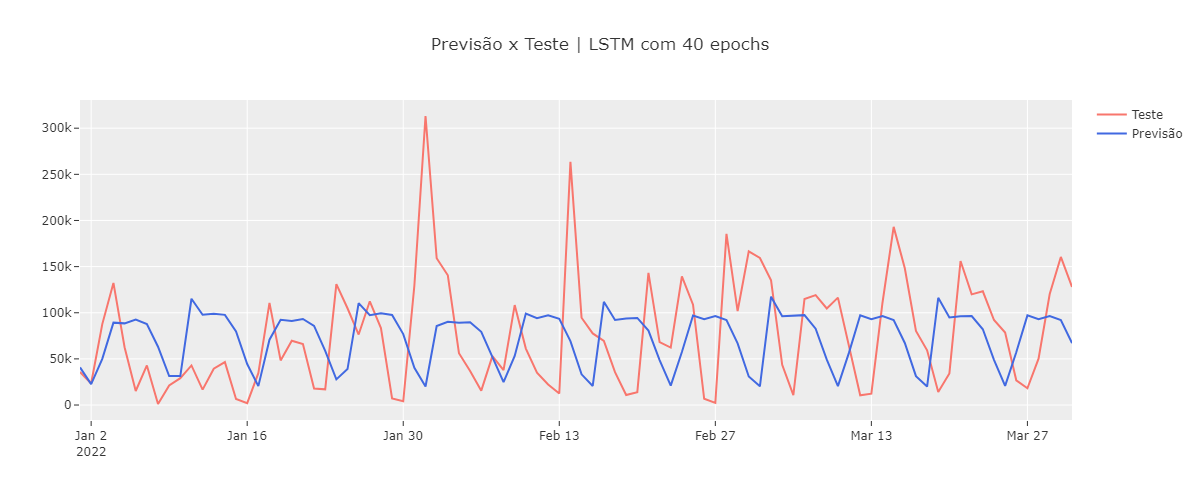

In [37]:
df_test.loc[:,'Prediction'] = all_predictions
fig = go.Figure([
    go.Scatter(x = df_test.index, y=df_test['VALOR'], mode='lines', name='Teste'),
    go.Scatter(x = df_test.index, y=df_test['Prediction'], mode='lines', line={'color': 'royalblue'}, name='Previsão')
])

fig.update_layout(title_text='Previsão x Teste | LSTM com 40 epochs',
                    height=500,
                    width=1200
)

fig.show(config=pxconfig)

In [38]:
fig.write_image("../plots/prevXtest_LSTM.jpeg")